## BANDIT IV

In [4]:
import numpy as np
import numpy.linalg as linalg
from scipy.stats import t as t_law
import matplotlib.pyplot as plt
from tqdm import tqdm
from icecream import ic
from numpy.linalg import inv

colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']
s_colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']

In [3]:
#game parameters
n_iter = 50         #number of simulations
T = 100             #time horizon
sigma_iv = 0.1         #standard deviation of endogenous noise
sigma_y = 0.1

K = 3       #number of bandits 
k = 10      #dim of Z
d = 5       #dimension of X

Gamma_star = np.random.randn(k,d)   # arms x features
Beta_star = np.random.randn(d,1)      # features

#algorithm parameters
gamma_z = 0.1 
gamma_x = 0.1
G_t = [np.inf for _ in range(T)]
B_t = [np.inf for _ in range(T)]

assert k >= d #assumption

#confidence sets #fill this out
C_1s = []
C_2s = []


    


In [6]:

t = 0
delta = 0.25
Lz = 100

B_t =  np.sqrt(gamma_x)+linalg.norm(Beta_star,2) \
    +  np.sqrt(2*np.log(4*t)/delta \
               + d*np.log(t*k/d \ 
                    +2*(t**2)*k*np.log(4*(d**2)*t/delta)*(Lz**2)*linalg.norm(Gamma_star,"fro") \
                    +t+Lz*np.sqrt(2*np.log(4*(d**2)*t/delta))*linalg.norm(Gamma_star,1)))

               
               
               


In [ ]:
    # first stage
    Z = np.random.randn(T,d)

    eps = sigma_1*np.random.randn(T, d)
    # e = np.zeros((T,d))
    X = np.dot(Z, theta_star) + e + eps
    # second stage
    # eta = eta_tilde + np.linalg.norm(eps, axis=1)  
    # eta = sigma_2*(eta_tilde + eps[:,:ee].sum(axis=1))/(sigma_1*(ee+1)) 
    eta = sigma_2*np.random.randn(T) 
    y = np.dot(X, beta_star) + rho*e[:,0] + eta



    rho = 1-2*np.random.binomial(1, 0.2, T)
    #np.random.binomial(1, 0.6, T) #np.array([2])
    # #1-2*np.random.binomial(1, 0.5, T)



In [23]:
S, sigma_1, sigma_2 = 1, 0.01, 0.0001
nb_exp, T, n_a, d = 100, int(1e3), 100, 20

theta_star = np.random.randn(d,d); #  theta_star *= 1/np.linalg.norm(theta_star) #maybe this can be changed
inv_theta_star = np.linalg.inv(theta_star)
beta_star = np.random.multivariate_normal([10 for i in range(d)], np.eye(d)).reshape(-1,) ; beta_star *= S/np.linalg.norm(beta_star)


# FIRST STAGE
# X_max = 100
Z = np.random.randn(nb_exp, T, n_a, d) #; Z /= np.max(np.linalg.norm(Z,axis=2))/X_max
eps = sigma_1*np.random.randn(nb_exp, T, n_a, d)
# eps = np.zeros((T,d))
X = np.dot(Z, theta_star) + eps

# SECOND STAGE
ee = d//4
eta_tilde = np.random.randn(nb_exp, T, n_a) 
# eta = (eta_tilde + np.sum(eps[:,:,:,:ee]))/(1+ee*sigma_1)*sigma_2
eta = sigma_2 * (eta_tilde + eps[:,:,:,:ee].sum(axis=-1))
X = X / np.max(np.linalg.norm(X, axis=3, keepdims = True), axis=2, keepdims=True) 
Y = np.dot(X, beta_star) + eta

In [24]:
X.shape

(100, 1000, 100, 20)

In [18]:
def random_sample_a(rho=None): 
    e = np.random.randn(1,K)                #endogenous component of X. 
    Z_dist = np.random.randn(k,K) 
    u = np.random.randn(d,K)    
    v = Beta_star.T @ u + e                 #scalar
    X_dist = (Gamma_star.T @ Z_dist) + u
    return (Z_dist.T[...,None], 
            X_dist.T[...,None],
            v.T[...,None])

def random_sample_b(rho):
    e = np.random.randn(d)
    Z_dist = np.random.uniform(low=-3., high=3., size=(k,K))
    eta = 0.1*np.random.randn(1) 
    u = np.random.randn(d,K)  
    X_dist = Z_dist*Gamma_star + e + u
    v = rho*e + eta
    return (Z_dist.T[...,None], 
            X_dist.T[...,None],
            v.T[...,None])


def construct_dataset(T, sample, rho=None): 
    z, x, v = sample(rho)
    Z_dist = np.zeros((T,z.shape[0],z.shape[1],z.shape[2]))
    X_dist = np.zeros((T,x.shape[0],x.shape[1],x.shape[2]))
    V = np.zeros((T,v.shape[0],v.shape[1], v.shape[2]))
    for t in range(T):
        Z_dist[t], X_dist[t], V[t] = sample(rho)
    return Z_dist, X_dist, V

In [19]:
sample = random_sample_b

In [20]:
a,b,c = construct_dataset(100, sample, rho=0.1)

ValueError: operands could not be broadcast together with shapes (10,) (10,5) 

In [11]:
a,b,c = construct_dataset(100, random_sample_a, rho=0.1)

print(a.shape)
print(b.shape)
print(c.shape)

(100, 3, 10, 1)
(100, 3, 5, 1)
(100, 3, 1, 1)


In [192]:
regret = np.zeros((n_iter, T))

for iteration in tqdm(range(n_iter)):

    Z_dataset, X_dataset, v_dataset = construct_dataset(T, sample)   
    
    Z_dist = Z_dataset[0] ; X_dist = X_dataset[0] ; v = v_dataset[0]  

    idx = np.random.choice(np.arange(Z_dist.shape[0]))          #choose arm at random
    z = Z_dist[idx] ; x = X_dist[idx] ; v = v[idx]              #get sampled z, x, y for this arm

    y = ((Gamma_star @ Beta_star).T @ z) + v                    #calculate scalar reward from sample
    Z = z ; X = x ; Y = y

    #intializing estimated parameter matrics
    U_0 = np.eye(k)*gamma_z         # k x k
    V_0 = np.zeros((k,d))           # k x d
    W_0 = np.eye(d)*gamma_x         # d x d
    Q_0 = np.zeros((d,1))           # d x 1
    
    #confidence sets #fill this out
    C_1s = [] ; C_2s = []
    U_s = [] ; W_s = []

    for t in range(1,T):

        U_t = U_0 + z @ z.T
        V_t = V_0 + z @ x.T     
        Gamma_est = inv(U_t) @ V_t          #shape : d x k
        X_est = (Z.T @ Gamma_est).T         #shape : d x (n rounds so far..) (different from paper)
        W_t = W_0 + X_est @ X_est.T         #operation is other way in paper but that yield 1x1 (not dxd)
        Q_t = Q_0 + X_est @ Y
        Beta_est = inv(W_t) @ Q_t           #shape : k x 1

        U_s.append(U_t) ; W_s.append(W_t)

        if t==1:
            C_1s.append(Gamma_est) ; C_2s.append(Beta_est)


        new_C1s = []
        for gamma in C_1s:
            gdiff = [(gamma[:,i] - Gamma_est[:,i]) for i in range(Gamma_est.shape[1])] # ||x||_A = sqrt(x'Ax) (index on columns) 
            if all([np.sqrt(g.T @ U_s[t-1] @ g) <= G_t[t-1] for g in gdiff]): 
                new_C1s.append(Gamma_est)
        C_1s = new_C1s

        new_C_2s = []
        for beta in C_2s:
            bdiff = (beta - Beta_est)
            if np.sqrt(bdiff.T @ W_s[t-1] @ bdiff) <= B_t[t]:
                new_C_2s.append(Beta_est)
        C_2s = new_C_2s

        # nature reveals Z_t
        Z_dist = Z_dataset[t] ; X_dist = X_dataset[t] ; v = v_dataset[t]  

        idx = np.argmax(
                    [np.max(
                        [np.max(
                            [((gamma.T @ z).T @ beta) for beta in C_2s]
                        ) for gamma in C_1s]
                    ) for z in Z_dist] 
                )

        # #play x corresponding to that z 
        z = Z_dist[idx] ; x = X_dist[idx] ; v = v[idx]
        y = ((Gamma_star @ Beta_star).T @ z) + v                    #calculate scalar reward from sample
        Z = z ; X = x ; Y = y


        # #update X, Z, Y
        Z = np.hstack([Z, z])
        X = np.hstack([X, x])
        Y = np.hstack([Y, y])

        U_0, V_0, W_0, Q_0 = U_t, V_t, W_t, Q_t



  0%|          | 0/50 [00:00<?, ?it/s]


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 2)

In [169]:

        # add to set once so that it isnt empty?
        U_s.append(U_t) ; W_s.append(W_t)     

        if len(C_1s)==0:
            C_1s.append(Gamma_est)
        gdiff = [(Gamma_est[:,i] - C_1s[-1][:,i])[...,None] for i in range(Gamma_est.shape[1])] # ||x||_A = sqrt(x'Ax) (index on columns) 
        if all([np.sqrt(g.T @ U_s[t-1] @ g) <= G_t[t-1] for g in gdiff]): 
            C_1s.append(Gamma_est)
        if len(C_2s)==0:
            C_2s.append(Beta_est)
        b = (Beta_est - C_2s[-1])
        if np.sqrt(b.T @ W_s[t-1] @ b) <= B_t[t]:
            C_2s.append(Beta_est)


        # nature reveals Z_t
        Z_dist, X_dist, v = sample_Z_X()
        # select z 
        idx = np.argmax(
                    [np.max(
                        [np.max(
                            [((gamma.T @ z).squeeze() @ beta) for beta in C_2s]
                        ) for gamma in C_1s]
                    ) for z in Z_dist] #fix this z
                )

        #play x corresponding to that z 
        z = Z_dist[idx] ; x = X_dist[idx] ; v = v[idx]
        y = ((Gamma_star @ Beta_star).T @ z.T) + v   #scalar
        z = z[...,None] ; x = x[...,None] 

        #update X, Z, Y
        Z = np.hstack([Z, z])
        X = np.hstack([X, x])
        Y = np.hstack([Y, y])
        
        U_0, V_0, W_0, Q_0 = U_t, V_t, W_t, Q_t


        #getting optimal arm
        idx_star = np.argmax([Gamma_star.T @ z_ta for z_ta in Z_dist])
        z_star = Z_dist[idx]
        y_star = np.dot((Gamma_star.T @ z_star), Beta_star)
        y_ = np.dot((Gamma_est.T @ z_star), Beta_est)

        regret[iteration, t] += np.abs(y_star - y_)
    

    


NameError: name 'sample_Z_X' is not defined

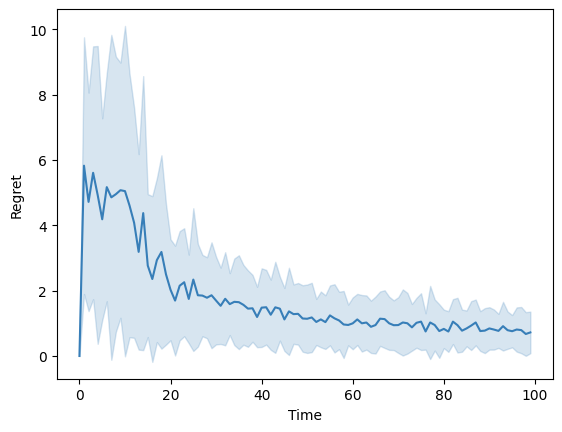

In [8]:
mean_regret = np.mean(regret, axis=0)
std_regret = np.std(regret, axis=0)


plt.plot(np.arange(T), mean_regret, color=colors[0])
plt.fill_between(np.arange(T), mean_regret - std_regret, mean_regret + std_regret, color=s_colors[0],alpha=0.2)
plt.xlabel("Time")
plt.ylabel('Regret')
plt.show()


In [15]:
from abc import ABC, abstractmethod

def unsqueeze(arr):
    return arr[...,None]


class SyntheticDataset: 
    def __init__(self, T, K, k, d, Gamma_star, Beta_star): 
        self.T = T ; self.K = K ; self.k = k ; self.d = d
        # Construct Z,X
        e = np.random.randn(T, K,1)            #endogenous component of X. 
        self.Z_dist = np.random.randn(T, K, k)      #instrumental variable. K arms. Related to X but exogenous wrt Y
        u = np.random.randn(T, K,d)
        v = Beta_star.T @ u[...,None] + e         #scalar
        self.v = v.squeeze()
        self.X_dist = (Gamma_star.T @ self.Z_dist[...,None]).squeeze() + u  # d  (IV + exogenous component + endogenous component)

    def sample_data(self,t):
        return self.Z_dist[t], self.X_dist[t], self.v[t][...,None]



class TwoStageBandit(ABC):
    def __init__(self, 
                n_iter, 
                time_horizon, 
                dataset):
        self.regret = np.zeros((n_iter, time_horizon))
        self.pulls = np.zeros((n_iter, time_horizon))

    @abstractmethod
    def reset(self):
        pass
    @abstractmethod
    def get_regret(self):
        pass


class BanditIV(TwoStageBandit):
    def __init__(self, 
                n_iter, 
                gamma_z, 
                gamma_x, 
                G_t, 
                B_t,
                Gamma_star, 
                Beta_star, 
                dataset
):
        super().__init__(self,n_iter,dataset.T)

        self.gamma_z = gamma_z
        self.gamma_x = gamma_x
        self.G_t = G_t
        self.B_t = B_t
        self.Gamma_star = Gamma_star
        self.Beta_star = Beta_star
        self.dataset = dataset

    def get_y(self, z, v): 
        return ((self.Gamma_star @ self.Beta_star).T @ z.T) + v   #scalar

    def reset(self, dataset):
        self.t = 0
        self.Z_dist, self.X_dist, v = dataset.sample_data(self.t)
        # choose arm associated with randomly chosen z
        idx = self.choose_arm()
        # select and observe reward
        z = self.Z_dist[idx] ; x = self.X_dist[idx] ; v = self.v[idx]
        self.z = z[...,None] ; self.x = x[...,None]
        self.y = self.get_y(z,v)
        self.Z = z ; self.X = x ; self.Y = self.y

        #intializing estimated parameter matrics
        self.U_0 = np.eye(self.dataset.k)*self.gamma_z         # k x k
        self.V_0 = np.zeros((self.dataset.k,self.dataset.d))           # k x d
        self.W_0 = np.eye(self.dataset.d)*self.gamma_x         # d x d
        self.Q_0 = np.zeros((self.dataset.d,1))           # d x 1

        #confidence sets
        self.C_1s = [] ; self.C_2s = []

        self.X_est = None
        self.Gamma_est = None
        
    def get_regret(self, t, iter, dataset):
        if self.t == 0: 
            return np.random.choice(np.arange(Z_dist.shape[0]))
        
        U_0 = self.U_0 ; V_0 = self.V_0
        W_0 = self.U_0 ; Q_0 = self.V_0
        z = self.z ; x = self.x ; y = self.y
        Z = self.Z ; X = self.X ; Y = self.Y
        C_1s = self.C_1s ; C_2s = self.C_2s
        
        U_t = U_0 + z @ z.T
        V_t = V_0 + z @ x.T     
        self.Gamma_est = inv(U_t) @ V_t          #shape : d x k
        self.X_est = (Z.T @ self.Gamma_est).T         #shape : d x (n rounds so far..) (different from paper)
        W_t = W_0 + self.X_est @ self.X_est.T         #operation is other way in paper but that yield 1x1 (not dxd)
        Q_t = Q_0 + (self.X_est @ Y)[...,None]       #had to remove transpose
        Beta_est = inv(W_t) @ Q_t           #shape : k x 1

        # add to set once so that it isnt empty?
        U_s.append(U_t) ; W_s.append(W_t)     
        if len(C_1s)==0:
            C_1s.append(Gamma_est)
        gdiff = [(Gamma_est[:,i] - C_1s[-1][:,i])[...,None] for i in range(Gamma_est.shape[1])] # ||x||_A = sqrt(x'Ax) (index on columns) 
        if all([np.sqrt(g.T @ U_s[t-1] @ g) <= G_t[t-1] for g in gdiff]): 
            C_1s.append(Gamma_est)
        if len(C_2s)==0:
            C_2s.append(Beta_est)
        b = (Beta_est - C_2s[-1])
        if np.sqrt(b.T @ W_s[t-1] @ b) <= B_t[t]:
            C_2s.append(Beta_est)

        # nature reveals Z_t
        Z_dist, X_dist, v = dataset.sample_data(t)
        # select z 
        idx = np.argmax(
                    [np.max(
                        [np.max(
                            [((gamma.T @ z).squeeze() @ beta) for beta in C_2s]
                        ) for gamma in C_1s]
                    ) for z in Z_dist] #fix this z
                )
        
        z = Z_dist[idx] ; x = X_dist[idx] ; v = v[idx]
        z = z[...,None] ; x = x[...,None] 
        y = self.get_y(z, v)

        #update X, Z, Y
        Z = np.hstack([Z, z])
        X = np.hstack([X, x])
        Y = np.hstack([Y, y])

        idx_star = np.argmax([Gamma_star.T @ z_ta for z_ta in Z_dist])
        z_star = Z_dist[idx]
        y_star = np.dot((Gamma_star.T @ z_star), Beta_star)
        y_ = np.dot((Gamma_est.T @ z_star), Beta_est)

        regret = np.abs(y_star - y_)
        
        self.U_0 = U_t ; self.W_0 = W_t ; self.V_t = V_t ; self.Q_0 = Q_t
        self.Z_dist = Z_dist ; self.X_dist = X_dist
        self.X = X ; self.Z = Z ; self.Y = Y
        self.x = x ; self.z = z ; self.y = y

        self.regret[iter, t] = regret
        self.pulls[iter,t] = idx
    
        
            
            

In [16]:
#game parameters
n_iter = 50         #number of simulations
T = 100             #time horizon
sigma_iv = 0.1         #standard deviation of endogenous noise
sigma_y = 0.1

K = 3       #number of bandits 
k = 10      #dim of Z
d = 5       #dimension of X

Gamma_star = np.random.randn(k,d)   # arms x features
Beta_star = np.random.randn(d)      # features

#algorithm parameters
gamma_z = 0.1 
gamma_x = 0.1
G_t = [1 for _ in range(T)]
B_t = [1 for _ in range(T)]

    

dataset = SyntheticDataset(T, K, k, d, Gamma_star, Beta_star)
bandit_iv = BanditIV(n_iter,gamma_z, gamma_x, G_t, B_t, Gamma_star, Beta_star, dataset)


bandits = [bandit_iv]


for iteration in tqdm(range(n_iter)):
    bandits = [bandit.reset() for bandit in bandits]
    for t in range(1,T):
        for bandit in bandits: 
            bandit.get_regret(t, iteration, dataset)
        
        


    


TypeError: 'BanditIV' object cannot be interpreted as an integer